# Importing libraries

In [1]:
# import libraries

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
 
from warnings import filterwarnings
filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.6f}'.format

from sklearn.model_selection import train_test_split

import statsmodels
import statsmodels.api as sm
from statsmodels.api import add_constant
from statsmodels.api import Logit

from sklearn.preprocessing import StandardScaler 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from IPython.display import Image 

plt.rcParams['figure.figsize'] = [15,8]

In [2]:
!pip install -U -q PyDrive
  
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/file/d/120wEsROzvOxOlIQSYAkoANMjlRcvRUFZ/view?usp=sharing'

# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('consumer_complaints.csv')  
  
consumer_complaints = pd.read_csv('consumer_complaints.csv')
consumer_complaints.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


# Data Preparation

In [4]:
# create copy of data
df = consumer_complaints.copy()

In [5]:
# dimension

df.shape

(555957, 18)

In [6]:
df.dtypes

date_received                   object
product                         object
sub_product                     object
issue                           object
sub_issue                       object
consumer_complaint_narrative    object
company_public_response         object
company                         object
state                           object
zipcode                         object
tags                            object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
complaint_id                     int64
dtype: object

In [7]:
df.drop(['complaint_id'], axis=1, inplace= True)

In [8]:
df.drop(['date_received', 'date_sent_to_company'], axis= 1, inplace= True)

In [9]:
df.rename(columns = {"consumer_disputed?": "consumer_disputed"}, inplace = True)

In [10]:
df.describe(include='all')

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,company_response_to_consumer,timely_response,consumer_disputed
count,555957,397635,555957,212622,66806,85124,555957,551070,551452,77959,123458,555957,555957,555957,555957
unique,11,46,95,68,65646,10,3605,62,27052,3,4,6,8,2,2
top,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",Account status,This company continues to report on my credit ...,Company chooses not to provide a public response,Bank of America,CA,300XX,Older American,Consent provided,Web,Closed with explanation,Yes,No
freq,186475,74319,97191,26798,37,52478,55998,81700,1205,45257,66807,361338,404293,541909,443823


In [11]:
df['consumer_disputed'].value_counts(normalize=True)

No    0.798305
Yes   0.201695
Name: consumer_disputed, dtype: float64

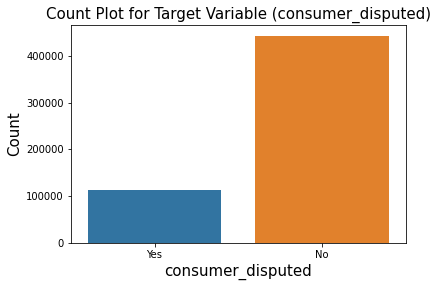

In [12]:
sns.countplot(df['consumer_disputed'])

plt.title('Count Plot for Target Variable (consumer_disputed)', fontsize = 15)
plt.xlabel('consumer_disputed', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.show()

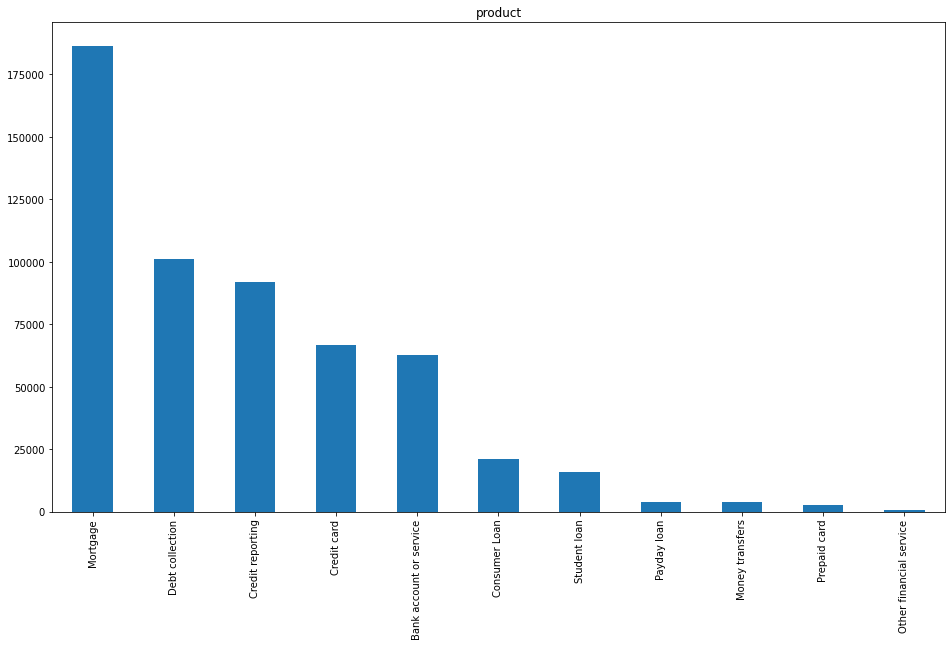

In [13]:
df['product'].value_counts().plot(kind='bar', title='product', figsize=(16,9))
plt.show()

In [14]:
Total = df.isnull().sum().sort_values(ascending=False)          
Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)   

missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    
missing_data

,Total,Percentage of Missing Values
consumer_complaint_narrative,489151,87.983603
tags,477998,85.977513
company_public_response,470833,84.688744
consumer_consent_provided,432499,77.793606
sub_issue,343335,61.755675
sub_product,158322,28.477382
state,4887,0.879025
zipcode,4505,0.810314
consumer_disputed,0,0.000000
timely_response,0,0.000000


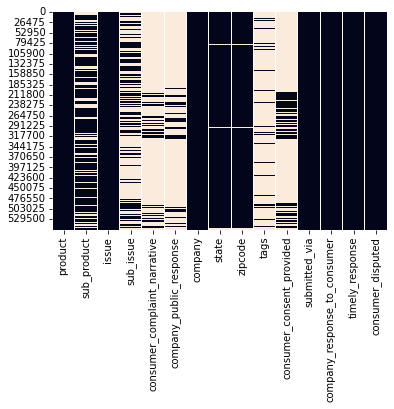

In [15]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [16]:
df_removed_na = df.drop(['consumer_complaint_narrative', 'tags', 'company_public_response', 
                           'consumer_consent_provided', 'sub_issue'], axis = 1)
df_removed_na.columns

Index(['product', 'sub_product', 'issue', 'company', 'state', 'zipcode',
       'submitted_via', 'company_response_to_consumer', 'timely_response',
       'consumer_disputed'],
      dtype='object')

In [17]:
df_removed_na = df_removed_na.dropna()

In [18]:
df_removed_na.shape

(393942, 10)

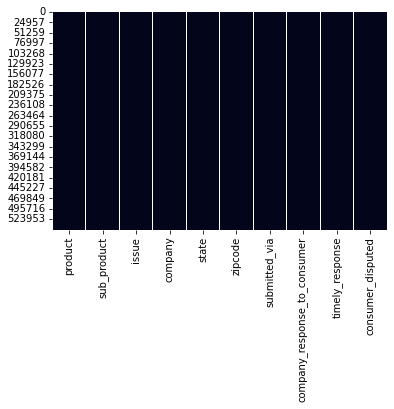

In [19]:
sns.heatmap(df_removed_na.isnull(), cbar=False)
plt.show()

In [153]:
df_removed_na['consumer_disputed'].value_counts(normalize=True)

No    0.790314
Yes   0.209686
Name: consumer_disputed, dtype: float64

missing values are treated

# Encode all variables

In [20]:
df_dummy = df_removed_na.copy()

In [21]:
df_dummy_encoded = df_dummy.copy()

In [22]:
df_dummy_encoded['consumer_disputed'] = df_dummy_encoded['consumer_disputed'].map({'No':0,'Yes':1})

In [23]:
# Target Encoding

for col in df_dummy.columns:
    m = df_dummy_encoded.groupby(col)['consumer_disputed'].mean()
    df_dummy_encoded[col] = df_dummy_encoded[col].map(m)

In [24]:
df_dummy_encoded.head()

,product,sub_product,issue,company,state,zipcode,submitted_via,company_response_to_consumer,timely_response,consumer_disputed
0,0.232357,0.202929,0.225879,0.225676,0.222513,0.321429,0.178073,0.225551,0.212770,1
1,0.232357,0.202929,0.237749,0.230271,0.222513,0.266667,0.178073,0.225551,0.212770,1
3,0.195840,0.196220,0.201263,0.188415,0.220026,0.500000,0.227848,0.225551,0.212770,1
4,0.181489,0.188838,0.208728,0.185869,0.200109,0.222222,0.228190,0.225551,0.212770,1
7,0.196769,0.189255,0.194781,0.221969,0.220241,0.277778,0.178073,0.225551,0.212770,0


# SMOTE Analysis

In [25]:
X = df_dummy_encoded.drop(['consumer_disputed'], axis =1)
df_target = df_dummy_encoded['consumer_disputed']

In [38]:
sm = SMOTE(sampling_strategy=0.95,random_state=0)
X,df_target = sm.fit_resample(X, df_target)

In [39]:
df_target.value_counts(normalize = True)

0   0.512821
1   0.487179
Name: consumer_disputed, dtype: float64

In [43]:
X.head()

,product,sub_product,issue,company,state,zipcode,submitted_via,company_response_to_consumer,timely_response
0,0.232357,0.202929,0.225879,0.225676,0.222513,0.321429,0.178073,0.225551,0.212770
1,0.232357,0.202929,0.237749,0.230271,0.222513,0.266667,0.178073,0.225551,0.212770
2,0.195840,0.196220,0.201263,0.188415,0.220026,0.500000,0.227848,0.225551,0.212770
3,0.181489,0.188838,0.208728,0.185869,0.200109,0.222222,0.228190,0.225551,0.212770
4,0.196769,0.189255,0.194781,0.221969,0.220241,0.277778,0.178073,0.225551,0.212770


# Train Test Split

In [44]:
X = add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, df_target, random_state = 10, test_size = 0.3)

print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (424976, 10)
y_train (424976,)
X_test (182133, 10)
y_test (182133,)


# Logistic Regression

In [46]:
logreg = Logit(y_train, X_train).fit()

print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.611548
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      consumer_disputed   No. Observations:               424976
Model:                          Logit   Df Residuals:                   424966
Method:                           MLE   Df Model:                            9
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.1173
Time:                        06:28:12   Log-Likelihood:            -2.5989e+05
converged:                       True   LL-Null:                   -2.9443e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -6.5445      0.092    -71.139      0.000

In [47]:
print('AIC:', logreg.aic)

AIC: 519806.71546713705


In [48]:
# Interpret the odds for each variable

df_odds = pd.DataFrame(np.exp(logreg.params), columns= ['Odds']) 

df_odds

,Odds
const,0.001438
product,0.038890
sub_product,2.929372
issue,81.083313
company,419.963195
state,0.248512
zipcode,729.947638
submitted_via,245.324682
company_response_to_consumer,933.302813
timely_response,72.270455


In [50]:
# predictions on the test set.

y_pred_prob = logreg.predict(X_test)

y_pred_prob.head()

42952    0.279657
481230   0.567492
439733   0.479150
523071   0.718283
560417   0.560652
dtype: float64

In [51]:
# convert probabilities to 0 and 1 using 'if_else'
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred_prob]
y_pred[0:5]

[0, 1, 0, 1, 1]

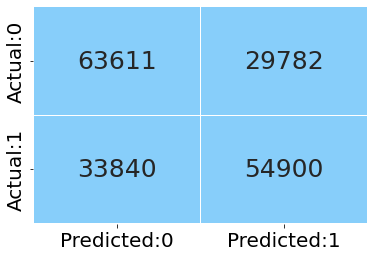

In [52]:
# create a confusion matrix

cm = confusion_matrix(y_test, y_pred)

conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])


sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [53]:
TN = cm[0,0]
TP = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [54]:
# performance metrics.

acc_table = classification_report(y_test, y_pred)

print(acc_table)

              precision    recall  f1-score   support

           0       0.65      0.68      0.67     93393
           1       0.65      0.62      0.63     88740

    accuracy                           0.65    182133
   macro avg       0.65      0.65      0.65    182133
weighted avg       0.65      0.65      0.65    182133



In [55]:
# kappa score
kappa = cohen_kappa_score(y_test, y_pred)

print('kappa value:',kappa)

kappa value: 0.3001141370044159


 As the kappa score for the full model (with cut-off probability 0.5) is 0.30, we can say that there is Fair agreement between the actual and predicted values.

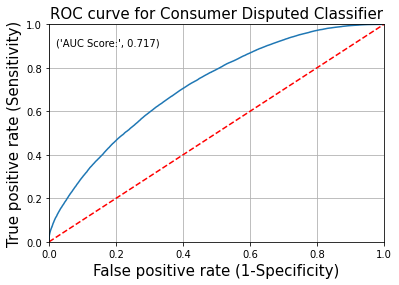

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.plot([0, 1], [0, 1],'r--')

plt.title('ROC curve for Consumer Disputed Classifier', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred_prob),4)))
                
plt.grid(True)

From the above plot, we can see that our classifier (logistic regression) is slightly away from the dotted line; with the AUC score 0.717.

In [57]:
# Identify the Best Cut-off Value using Youden's Index

youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': thresholds})

youdens_table['Difference'] = youdens_table.TPR - youdens_table.FPR

youdens_table = youdens_table.sort_values('Difference', ascending = False).reset_index(drop = True)

youdens_table.head()

,TPR,FPR,Threshold,Difference
0,0.703775,0.397888,0.461709,0.305887
1,0.703595,0.397717,0.461795,0.305878
2,0.703809,0.397931,0.461697,0.305878
3,0.703696,0.397824,0.461754,0.305872
4,0.703651,0.397781,0.461775,0.305870


As we can see that the optimal cut-off probability is approximately 0.46. Let us consider this cut-off to predict the target values. i.e. if 'y_pred_prob' is less than 0.46, then consider it to be 0 else consider it to be 1.

In [66]:
y_pred_youden = [ 0 if x < 0.46 else 1 for x in y_pred_prob]

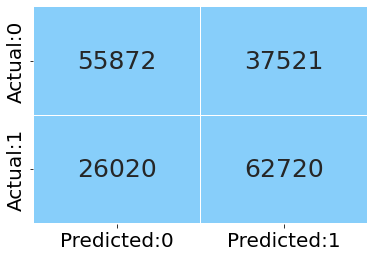

In [67]:
cm = confusion_matrix(y_test, y_pred_youden)

conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [68]:
acc_table = classification_report(y_test, y_pred_youden)

print(acc_table)

              precision    recall  f1-score   support

           0       0.68      0.60      0.64     93393
           1       0.63      0.71      0.66     88740

    accuracy                           0.65    182133
   macro avg       0.65      0.65      0.65    182133
weighted avg       0.65      0.65      0.65    182133



In [69]:
# compared to previous score card the specificity and sensitivity here are little comparable 

kappa = cohen_kappa_score(y_test, y_pred_youden)
print('kappa value:',kappa)

kappa value: 0.3040483547765992


# Recursive Feature Elimination (RFE)

In [70]:
X_train_rfe = X_train.iloc[:,1:]
X_test_rfe = X_test.iloc[:,1:]

logreg = LogisticRegression()

rfe_model = RFE(estimator = logreg, n_features_to_select = 5)

rfe_model = rfe_model.fit(X_train_rfe, y_train)

feat_index = pd.Series(data = rfe_model.ranking_, index = X_train_rfe.columns)

signi_feat_rfe = feat_index[feat_index==1].index

print(signi_feat_rfe)

Index(['company', 'zipcode', 'submitted_via', 'company_response_to_consumer',
       'timely_response'],
      dtype='object')


In [71]:
# Build the logisitc regression model using the variables obtained from RFE.

logreg_rfe = Logit(y_train, X_train[['company', 'zipcode', 'submitted_via', 'company_response_to_consumer',
                                        'timely_response']]).fit()

print(logreg_rfe.summary())

Optimization terminated successfully.
         Current function value: 0.627271
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      consumer_disputed   No. Observations:               424976
Model:                          Logit   Df Residuals:                   424971
Method:                           MLE   Df Model:                            4
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                 0.09461
Time:                        06:33:25   Log-Likelihood:            -2.6658e+05
converged:                       True   LL-Null:                   -2.9443e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
company                          5.2604      0.066     79.715      0.000

In [72]:
y_pred_prob_rfe = logreg_rfe.predict(X_test[['company', 'zipcode', 'submitted_via', 'company_response_to_consumer',
                                        'timely_response']])

y_pred_prob_rfe.head()

42952    0.343174
481230   0.626915
439733   0.436523
523071   0.742123
560417   0.565110
dtype: float64

In [73]:
y_pred_rfe = [ 0 if x < 0.46 else 1 for x in y_pred_prob_rfe]

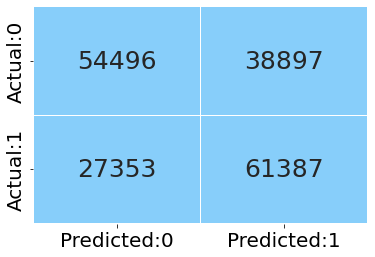

In [74]:
cm = confusion_matrix(y_test, y_pred_rfe)

conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [75]:
result = classification_report(y_test, y_pred_rfe)

print(result)

              precision    recall  f1-score   support

           0       0.67      0.58      0.62     93393
           1       0.61      0.69      0.65     88740

    accuracy                           0.64    182133
   macro avg       0.64      0.64      0.64    182133
weighted avg       0.64      0.64      0.64    182133



In [76]:
kappa = cohen_kappa_score(y_test, y_pred_rfe)

print('kappa value:',kappa)

kappa value: 0.2743859595274286


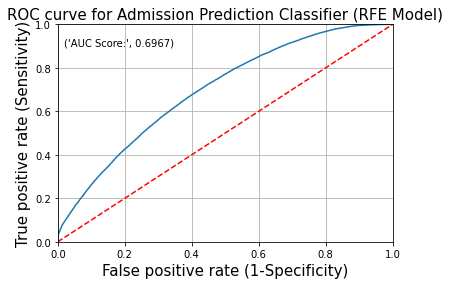

In [77]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rfe)

plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.plot([0, 1], [0, 1],'r--')

plt.title('ROC curve for Admission Prediction Classifier (RFE Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred_prob_rfe),4)))
plt.grid(True)

# Decision Tree

In [78]:
# Generelized functions to get performance metrics on train and test data

def get_train_report(model):
     
    train_pred = model.predict(X_train)
    
    return(classification_report(y_train, train_pred))

def get_test_report(model):

    test_pred = model.predict(X_test)
    
    return(classification_report(y_test, test_pred))

In [79]:
decision_tree_classification = DecisionTreeClassifier(criterion = 'entropy', random_state = 10)

decision_tree = decision_tree_classification.fit(X_train, y_train)

In [80]:
train_report = get_train_report(decision_tree)

print(train_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    217945
           1       0.99      0.98      0.98    207031

    accuracy                           0.99    424976
   macro avg       0.99      0.99      0.99    424976
weighted avg       0.99      0.99      0.99    424976



In [81]:
test_report = get_test_report(decision_tree)

print(test_report)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     93393
           1       0.79      0.78      0.78     88740

    accuracy                           0.79    182133
   macro avg       0.79      0.79      0.79    182133
weighted avg       0.79      0.79      0.79    182133



From the above output, we can see that there is a difference between the train and test accuracy; thus, we can conclude that the decision tree is over-fitted on the train data.

If we tune the hyperparameters in the decision tree, it helps to avoid the over-fitting of the tree.

In [82]:
dt_model = DecisionTreeClassifier(criterion = 'gini',
                                  max_depth = 5,
                                  min_samples_split = 4,
                                  max_leaf_nodes = 6,
                                  random_state = 10)

decision_tree = dt_model.fit(X_train, y_train)

train_report = get_train_report(decision_tree)

print('Train data:\n', train_report)

test_report = get_test_report(decision_tree)

print('Test data:\n', test_report)

Train data:
               precision    recall  f1-score   support

           0       0.65      0.66      0.66    217945
           1       0.64      0.63      0.63    207031

    accuracy                           0.65    424976
   macro avg       0.64      0.64      0.64    424976
weighted avg       0.65      0.65      0.65    424976

Test data:
               precision    recall  f1-score   support

           0       0.65      0.66      0.66     93393
           1       0.64      0.63      0.63     88740

    accuracy                           0.64    182133
   macro avg       0.64      0.64      0.64    182133
weighted avg       0.64      0.64      0.64    182133



 From the above output, we can see that there is nearly no difference between the train and test accuracy, hence we can conclude that the decision tree is less over-fiited after specifying some of the hyperparameters.

# Tune the Hyperparameters using GridSearchCV (Decision Tree)

In [ ]:
tuned_paramaters = [{'criterion': ['entropy', 'gini'], 
                     'max_depth': range(2, 10),
                     'max_features': ["sqrt", "log2"],
                     'min_samples_split': range(2,10),
                     'min_samples_leaf': range(1,10),
                     'max_leaf_nodes': range(1, 10)}]
 
decision_tree_classification = DecisionTreeClassifier(random_state = 10)

tree_grid = GridSearchCV(estimator = decision_tree_classification, 
                         param_grid = tuned_paramaters, 
                         cv = 5)

tree_grid_model = tree_grid.fit(X_train, y_train)

print('Best parameters for decision tree classifier: ', tree_grid_model.best_params_, '\n')

Best parameters for decision tree classifier:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'min_samples_split': 2} 



Building the model using the tuned hyperparameters.

In [83]:
dt_model = DecisionTreeClassifier(criterion = 'gini',
                                  max_depth = 5,
                                  max_features = 'sqrt',
                                  max_leaf_nodes = 9,
                                  min_samples_leaf = 1,
                                  min_samples_split = 2,
                                  random_state = 10)

dt_model = dt_model.fit(X_train, y_train)

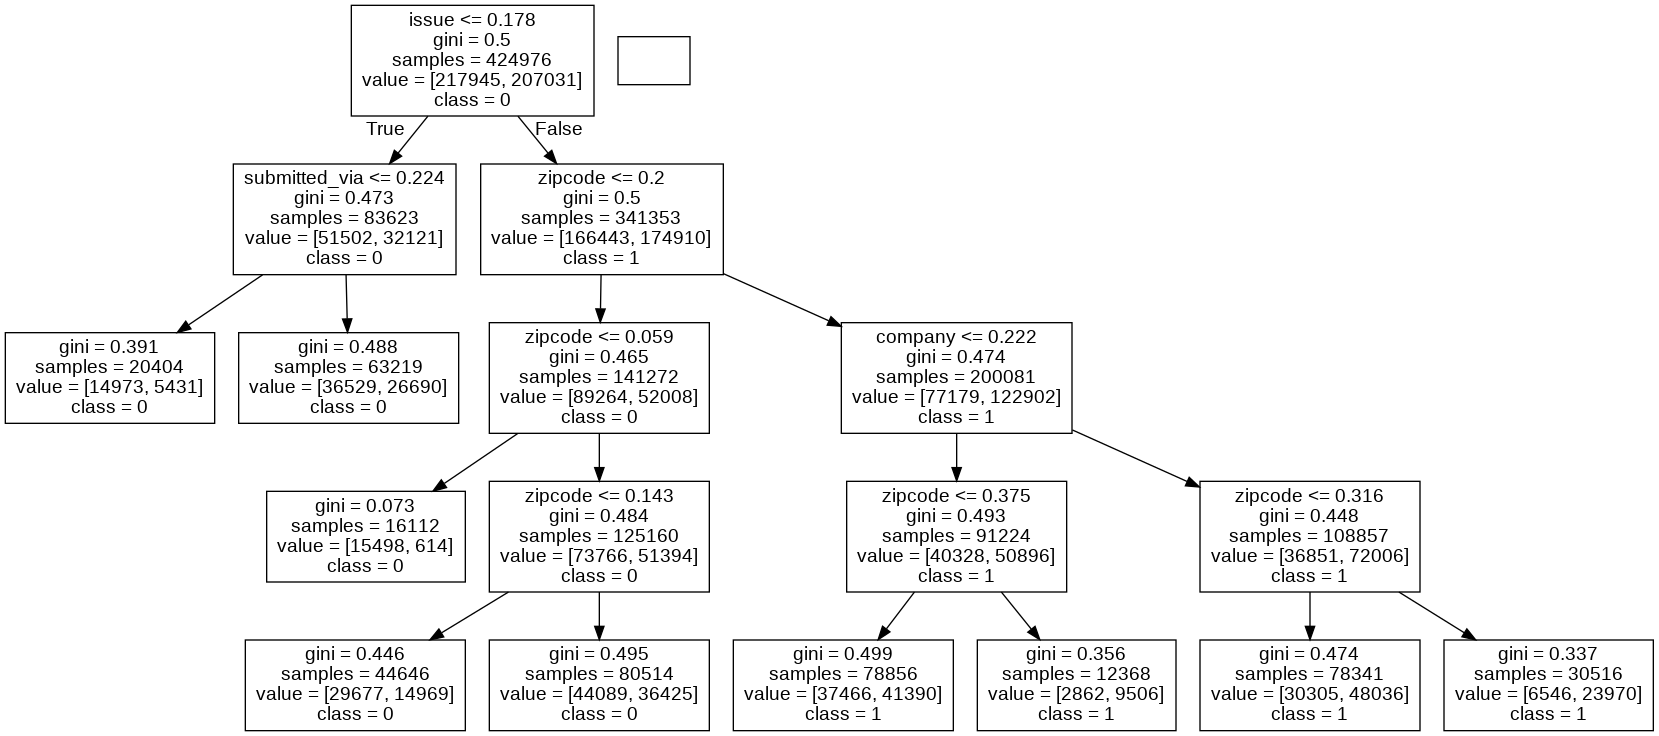

In [84]:
labels = X_train.columns

dot_data = tree.export_graphviz(dt_model, feature_names = labels, class_names = ["0","1"])  

graph = pydotplus.graph_from_dot_data(dot_data)  

Image(graph.create_png())

In [85]:
# performance measures on the train set

print('Classification Report for train set: \n', get_train_report(dt_model))

Classification Report for train set: 
               precision    recall  f1-score   support

           0       0.63      0.65      0.64    217945
           1       0.61      0.59      0.60    207031

    accuracy                           0.62    424976
   macro avg       0.62      0.62      0.62    424976
weighted avg       0.62      0.62      0.62    424976



The accuracy is 0.62

In [86]:
# performance measures on the test set

print('Classification Report for test set: \n', get_test_report(dt_model))

Classification Report for test set: 
               precision    recall  f1-score   support

           0       0.63      0.65      0.64     93393
           1       0.62      0.59      0.60     88740

    accuracy                           0.62    182133
   macro avg       0.62      0.62      0.62    182133
weighted avg       0.62      0.62      0.62    182133



From the above output, we can see that there is no significant difference between the train and test accuracy; thus, we can conclude that the decision tree after tuning the hyperparameters avoids the over-fitting of the data.

# Random Forest

In [87]:
rf_classification = RandomForestClassifier(n_estimators = 10, random_state = 10)

rf_model = rf_classification.fit(X_train, y_train)

In [88]:
train_report = get_train_report(rf_model)

print(train_report) 

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    217945
           1       0.98      0.97      0.97    207031

    accuracy                           0.98    424976
   macro avg       0.98      0.98      0.98    424976
weighted avg       0.98      0.98      0.98    424976



In [89]:
test_report = get_test_report(rf_model)

print(test_report)

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     93393
           1       0.86      0.78      0.82     88740

    accuracy                           0.83    182133
   macro avg       0.83      0.83      0.83    182133
weighted avg       0.83      0.83      0.83    182133



In [90]:
# To avoid Overfitting

rfa_model = RandomForestClassifier(criterion = 'gini',
                                  max_depth = 5,
                                  min_samples_split = 4,
                                  max_leaf_nodes = 6,
                                  random_state = 10)

random_forest = rfa_model.fit(X_train, y_train)

train_report = get_train_report(random_forest)

print('Train data:\n', train_report)

test_report = get_test_report(random_forest)

print('Test data:\n', test_report)

Train data:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67    217945
           1       0.65      0.62      0.63    207031

    accuracy                           0.65    424976
   macro avg       0.65      0.65      0.65    424976
weighted avg       0.65      0.65      0.65    424976

Test data:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67     93393
           1       0.65      0.62      0.63     88740

    accuracy                           0.65    182133
   macro avg       0.65      0.65      0.65    182133
weighted avg       0.65      0.65      0.65    182133



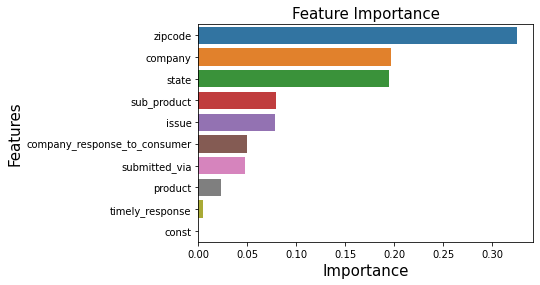

In [91]:
# Feature Importance

important_features = pd.DataFrame({'Features': X_train.columns, 
                                   'Importance': rf_model.feature_importances_})

important_features = important_features.sort_values('Importance', ascending = False)

sns.barplot(x = 'Importance', y = 'Features', data = important_features)

plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.show()

From the above bar plot, we can see that zipcode is the most important feature in the dataset.i.e, which region is getting more consumer complaints

# AdaBoost

In [92]:
ada_model = AdaBoostClassifier(n_estimators = 40, random_state = 10)

ada_model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=40, random_state=10)

In [93]:
# Generalised functions

def plot_confusion_matrix(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
                linewidths = 0.1, annot_kws = {'size':25})

    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()

def get_test_report(model):
    
    test_pred = model.predict(X_test)

    return(classification_report(y_test, test_pred))

def plot_roc(model):
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1],'r--')

    plt.title('ROC curve for Admission Prediction Classifier', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
    plt.text(x = 0.82, y = 0.3, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))
    plt.grid(True)

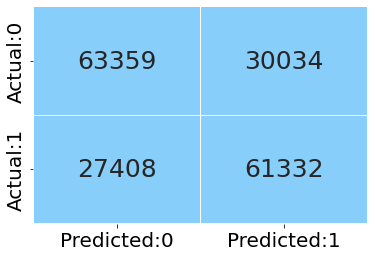

In [94]:
plot_confusion_matrix(ada_model)

In [95]:
test_report = get_test_report(ada_model)

print(test_report)

              precision    recall  f1-score   support

           0       0.70      0.68      0.69     93393
           1       0.67      0.69      0.68     88740

    accuracy                           0.68    182133
   macro avg       0.68      0.68      0.68    182133
weighted avg       0.69      0.68      0.68    182133



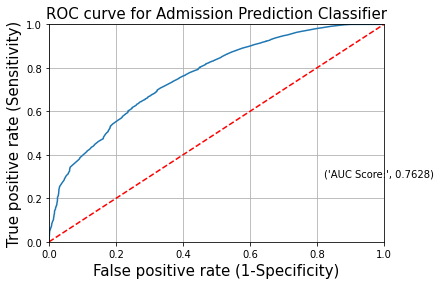

In [96]:
plot_roc(ada_model)

# Gradient Boosting

In [97]:
gboost_model = GradientBoostingClassifier(n_estimators = 150, max_depth = 10, random_state = 10)

# fit the model using fit() on train data
gboost_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, n_estimators=150, random_state=10)

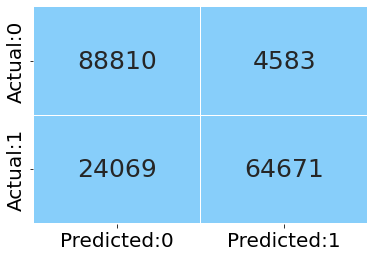

In [98]:
plot_confusion_matrix(gboost_model)

In [99]:
test_report = get_test_report(gboost_model)

print(test_report)

              precision    recall  f1-score   support

           0       0.79      0.95      0.86     93393
           1       0.93      0.73      0.82     88740

    accuracy                           0.84    182133
   macro avg       0.86      0.84      0.84    182133
weighted avg       0.86      0.84      0.84    182133



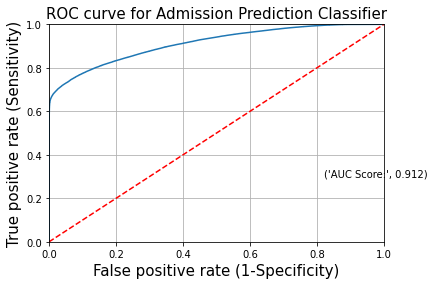

In [100]:
plot_roc(gboost_model)

In [109]:
# To avoid overfitting

gboost_grid_model = GradientBoostingClassifier(n_estimators = 100, max_depth = 5, random_state = 10)

gb_model = gboost_grid_model.fit(X_train, y_train)

train_report = get_train_report(gb_model)

print('Train data:\n', train_report)

test_report = get_test_report(gb_model)

print('Test data:\n', test_report)

Train data:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82    217945
           1       0.84      0.74      0.78    207031

    accuracy                           0.80    424976
   macro avg       0.81      0.80      0.80    424976
weighted avg       0.80      0.80      0.80    424976

Test data:
               precision    recall  f1-score   support

           0       0.77      0.86      0.82     93393
           1       0.84      0.73      0.78     88740

    accuracy                           0.80    182133
   macro avg       0.80      0.80      0.80    182133
weighted avg       0.80      0.80      0.80    182133



# XGBoost

In [101]:
xgb_model = XGBClassifier(max_depth = 10, gamma = 1)

xgb_model.fit(X_train, y_train)

XGBClassifier(gamma=1, max_depth=10)

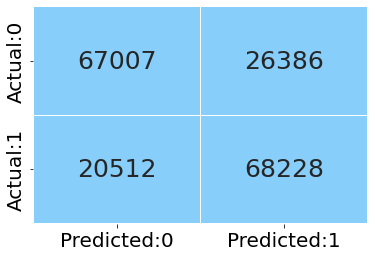

In [102]:
plot_confusion_matrix(xgb_model)

In [103]:
test_report = get_test_report(xgb_model)

print(test_report)

              precision    recall  f1-score   support

           0       0.77      0.72      0.74     93393
           1       0.72      0.77      0.74     88740

    accuracy                           0.74    182133
   macro avg       0.74      0.74      0.74    182133
weighted avg       0.74      0.74      0.74    182133



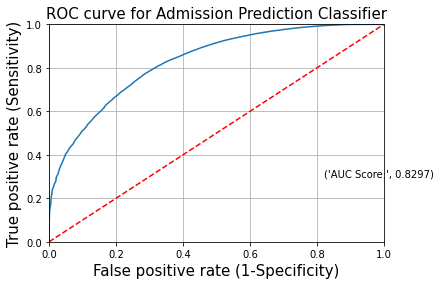

In [104]:
plot_roc(xgb_model)

# Tune the Hyperparameters (GridSearchCV) - for XGBoost model

In [91]:
tuning_parameters = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                     'max_depth': range(3,10),
                     'gamma': [0, 1, 2, 3, 4]}

xgb_model = XGBClassifier()

xgb_grid = GridSearchCV(estimator = xgb_model, param_grid = tuning_parameters, cv = 3, scoring = 'roc_auc')

xgb_grid.fit(X_train, y_train)

print('Best parameters for XGBoost classifier: ', xgb_grid.best_params_, '\n')

Best parameters for XGBoost classifier:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7} 



In [105]:
# Build the model using the tuned hyperparameters.

xgb_grid_model = XGBClassifier(learning_rate = 0.1,
                               max_depth = 7,
                              gamma = 0)

xgb_model = xgb_grid_model.fit(X_train, y_train)

print('Classification Report for test set:\n', get_test_report(xgb_model))

Classification Report for test set:
               precision    recall  f1-score   support

           0       0.74      0.69      0.71     93393
           1       0.69      0.75      0.72     88740

    accuracy                           0.72    182133
   macro avg       0.72      0.72      0.72    182133
weighted avg       0.72      0.72      0.72    182133



The f1-score is 0.71 and accuracy is 0.72

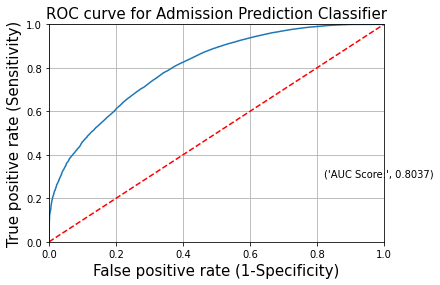

In [106]:
plot_roc(xgb_model)

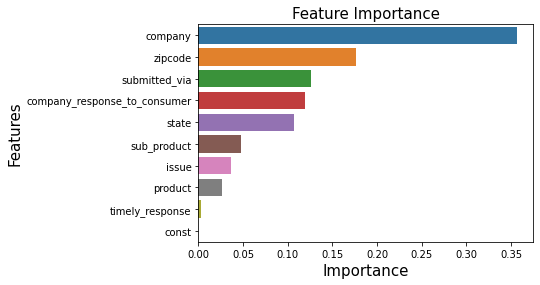

In [107]:
# Identifying the Important Features using XGBoost

important_features = pd.DataFrame({'Features': X_train.columns, 
                                   'Importance': xgb_model.feature_importances_})

important_features = important_features.sort_values('Importance', ascending = False)

sns.barplot(x = 'Importance', y = 'Features', data = important_features)

plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.show()

From the above bar plot, we can see that zipcode is the  company is the most important feature

# Final Analysis


Logistic Regression : Kappa Score is 0.21, Sensitivity to specificity Ratio is 0.69 to 0.58, accuracy is 0.64, ROC-AUC score is 0.696



Decision Tree(with tuned Hyperparameters) : Sensitivity to specificity Ratio is 0.59 to 0.65, accuracy is 0.62

Random Forest : Sensitivity to specificity Ratio is 0.62 to 0.68, accuracy is 0.65

XGBoost(with tuned Hyperparameters)  : Sensitivity to specificity Ratio is 0.75 to 0.69, accuracy is 0.72, ROC-AUC score is 0.80



We can conclude that the XGBoost performance is better compared to other models with the ROC-AUC score of 0.80 and Sensitivity to specificity Ratio 0.75 to 0.69